# Clustering Records by ZipCode

## Read in cleaned data

In [124]:
import pandas as pd
import json

cleaned_csv_path = r'../Database/processed/form_1_cleaned.csv'

code_dict_path = r'../Database/processed/code_dict.json'

df = pd.read_csv(cleaned_csv_path)

with open(code_dict_path, 'r') as file:
    code_dict = json.load(file)



C:\Users\benol\AppData\Local\Temp\ipykernel_12264\2492411773.py:8: DtypeWarning:

Columns (370,371,372) have mixed types. Specify dtype option on import or set low_memory=False.



# Form 1 Correlations
### Create Dendrogram to inform label clusters

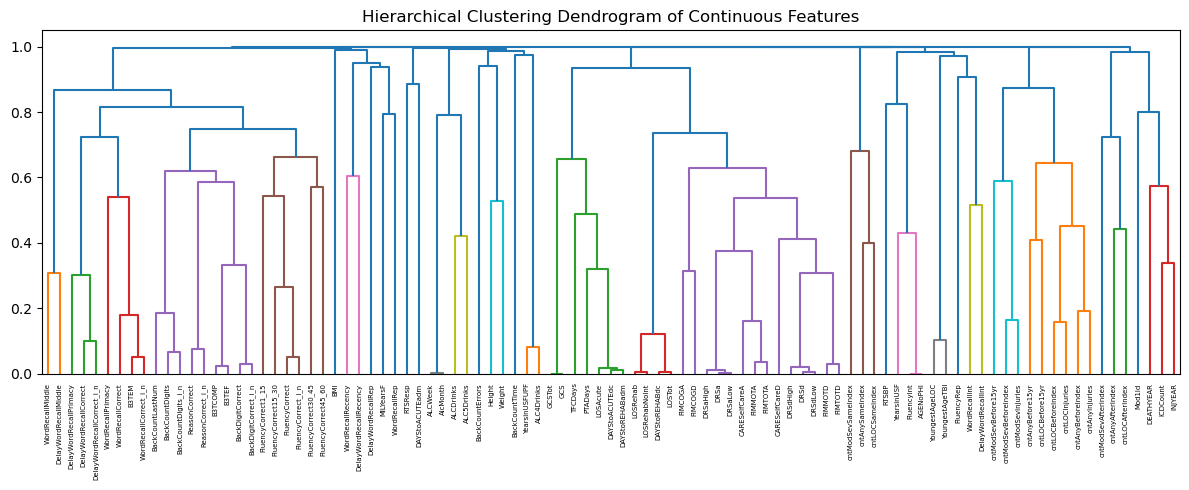

In [ ]:

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

#continuous columns as recorded in the code dictionary
cont_cols = code_dict["numeric_cols"]

#select continuous columns
df_cont = df[cont_cols]
df_cont = df_cont.loc[:, df_cont.std() != 0] #ignore columns with no variation


#compute absolute correlation and dissimilarity
correlation_matrix = df_cont.corr()
dissimilarity = 1 - abs(correlation_matrix)
dissimilarity.fillna(1.0, inplace=True)  #treat uncorrelated pairs as maximally dissimilar


#condense the dissimilarity matrix
dissimilarity_condensed = squareform(dissimilarity.values, checks=False)

#perform linkage and plot dendrogram
Z = linkage(dissimilarity_condensed, 'complete')

plt.figure(figsize=(12, 5))
dendrogram(Z, labels=df_cont.columns, orientation='top', leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram of Continuous Features")
plt.tight_layout()
plt.show()

### Create Correlation matrix of Continuous Variables (Grouped by fcluster)

[33 15 15 19 11 24 23 17 13 14 14 17  7  3  1  6  3  8 26  4  5  5  5  5
  5 27 23  4  4 16  4 18  2  1  6  2  9 26 13 23  4  4  3  4  4 10 21 21
 30 29 29 29 22 30 29 29 29 22 31 28 28 28 22 12 19 19 20 32  2 21 21 21
 21 21 21 21 21 21 21 21 21  5 19 32 32 19 20 20 20 19  4 19  3 25 25]


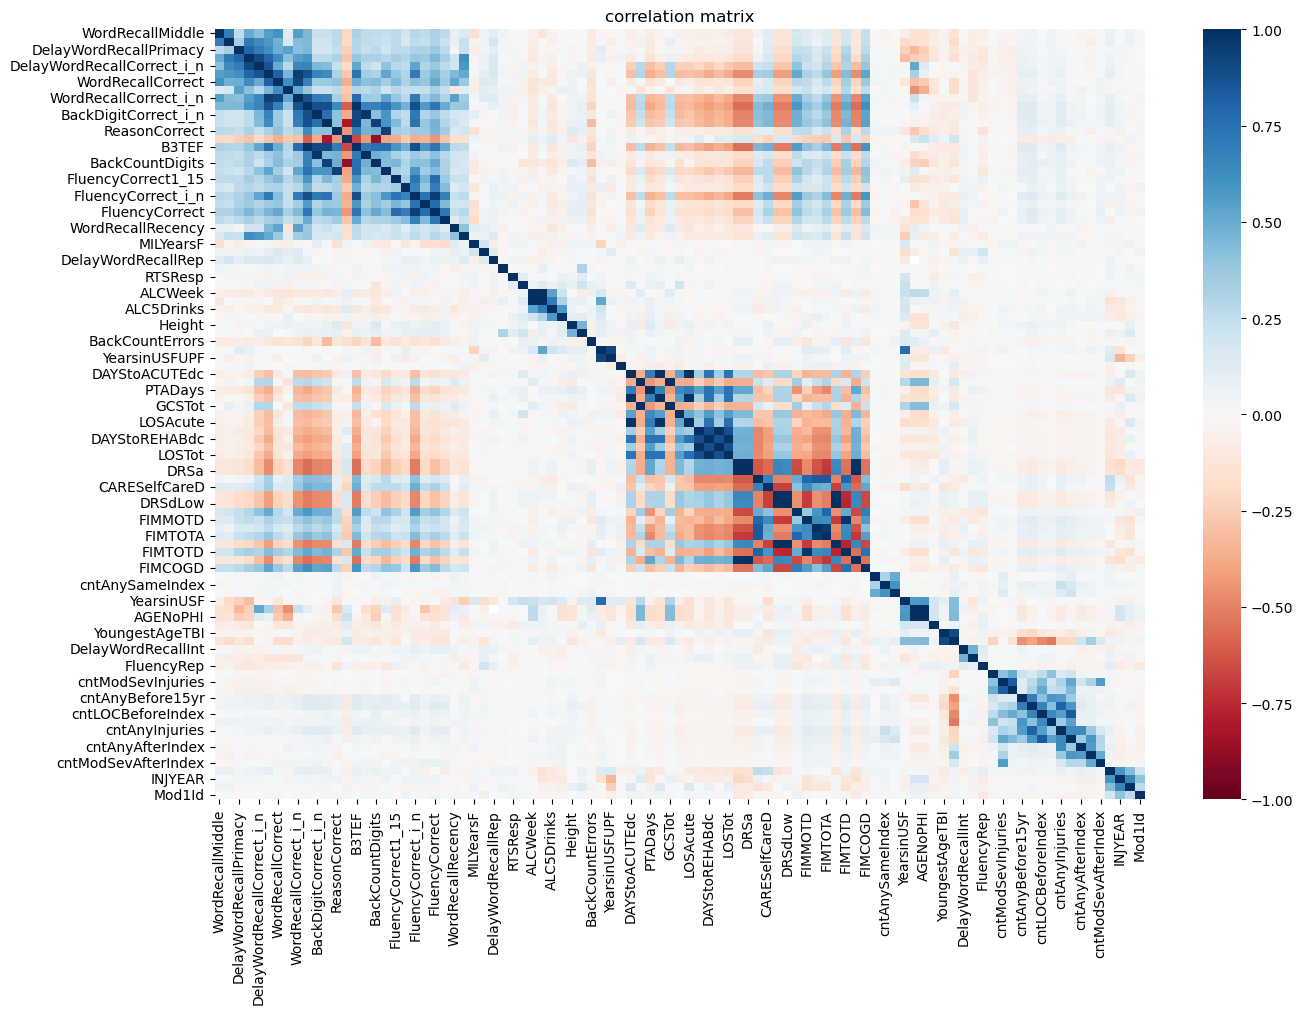

In [ ]:
import numpy as np
import seaborn as sns


#get cluster labels
threshold = 0.7
labels = fcluster(Z, threshold, criterion="distance")
print(labels)

#sort labels
labels_order = np.argsort(labels)

#rebuild dataframe in labels order
for idx, i in enumerate(df_cont.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df_cont[i])
    else:
        df_to_append = pd.DataFrame(df_cont[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

#create correlation matrix
clustered_corr = clustered.corr()

#plot
plt.figure(figsize=(15,10))
sns.heatmap(round(clustered_corr,2),cmap='RdBu', annot=False, 
            annot_kws={"size": 7}, vmin=-1, vmax=1)
plt.title("correlation matrix for continuous variables")
plt.show()

# Clustering features by Location

The idea was to see if any locations would have a remarkable difference in feature expression, possibily indicating hotspots for injury, locations with different reliability in data collection methods etc. The result was that mobility outcomes seem to be different between locations, but needs further investigation.

In [127]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.impute import SimpleImputer
# from sklearn.feature_selection import VarianceThreshold
# import gower
# import hdbscan



# #remove patient number, zip, and death year
# zip_codes = df['ZipInj']

# df_working = df.drop(columns=['ZipInj', 'Mod1Id', 'INJYEAR'])


# #remove columns with too many missing values or low variance 
# df_working = df_working.loc[:, df.isnull().mean() < 0.3] #drops columns with 30% missing data



# var_thresh = VarianceThreshold(threshold=0.01) 
# df_filtered = pd.DataFrame(var_thresh.fit_transform(df_working), columns=df_working.columns[var_thresh.get_support()])

# #handle missing values
# imputer = SimpleImputer(strategy='most_frequent')
# df_imputed = pd.DataFrame(imputer.fit_transform(df_filtered), columns=df_filtered.columns)

# #normalize continuous features
# scaler = MinMaxScaler()
# dropped_columns = [col for col in cont_cols if col not in df_imputed.columns] #all columns that were dropped for missing too much data.
# print("Missing columns:", dropped_columns)

# new_cont_cols = [col for col in cont_cols if col not in dropped_columns]

# df_imputed[new_cont_cols] = scaler.fit_transform(df_imputed[new_cont_cols])

# #computer gower distance matrix
# gower_matrix = gower.gower_matrix(df_imputed)
# gower_matrix = gower_matrix.astype(np.float64) #found out the hard way HDBSCAN does not work with float32 because it is based on c++ I think


# #cluster
# clusterer = hdbscan.HDBSCAN(metric="precomputed", min_cluster_size=10)
# labels = clusterer.fit_predict(gower_matrix)

# df_with_clusters = df_imputed.copy()
# df_with_clusters['cluster'] = labels

# #buckle up this takes like 5 minutes to fit


In [ ]:
# import umap.umap_ as umap
# from sklearn.manifold import TSNE


# #dimensionality reduction for visualization
# print(np.unique(labels))


# reducer = umap.UMAP(metric='precomputed') #must match metric for HDBSCAN
# embedding = reducer.fit_transform(gower_matrix)

#UMAP 2D embedding and cluster labels
# embedding_df = pd.DataFrame({
#     'UMAP1': embedding[:, 0],
#     'UMAP2': embedding[:, 1],
#     'cluster': labels  # array of cluster labels including -1 for noise
# })

# #Convert cluster column to categorical so seaborn doesn't treat it as continuous
# embedding_df['cluster'] = embedding_df['cluster'].astype(str)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(
#     data=embedding_df,
#     x='UMAP1', y='UMAP2',
#     hue='cluster',
#     palette='tab10',  # or use sns.color_palette('hls', n_colors)
#     s=15,
#     alpha=0.8
# )
# plt.title('HDBSCAN Clusters via UMAP')
# plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

# # #visualize via TSNE
# # tsne = TSNE(metric="precomputed", init='random', random_state=42)
# # embedding_tsne = tsne.fit_transform(gower_matrix)

# # plt.scatter(embedding_tsne[:,0], embedding_tsne[:, 1], c=labels, cmap='Spectral')
# # plt.title("t-SNE of Clusters")

In [129]:
# from sklearn.ensemble import RandomForestClassifier

# #determine feature importance

# importances = RandomForestClassifier().fit(df_imputed, labels).feature_importances_
# importance_df = pd.DataFrame({
#     'feature' : df_imputed.columns,
#     'importance' : importances
# }).sort_values(by='importance', ascending=False)

# print(importance_df.head())



In [130]:
# import seaborn as sns

# top_features = importance_df.head(10)

# plt.figure(figsize=(8, 6))
# sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
# plt.title('Top 10 Feature Importances for Predicting ZIP Code Clusters')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.tight_layout()
# plt.show()

# Clustering by Zipcode Coordinates
Note: each zipcode gets exactly 1 x:y coordinate. I tried using the actual coordinates for the barriers of the zipcodes and that was computationally heavy. 

### Plotting Zipcode distribution

In [ ]:

import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import plotly.graph_objects as go

nomi = pgeocode.Nominatim('us')

#create zipcodes count
zipcodes_count = df['ZipInj'].value_counts().reset_index()
zipcodes_count.columns = ['zipcode', 'count']

#zero pad zipcodes and convert to string
zipcodes_count['zipcode'] = zipcodes_count['zipcode'].astype(int).astype(str).str.zfill(5) #to zero pad zipcodes

#grab zipcode coordinates
geo_info = nomi.query_postal_code(zipcodes_count['zipcode'].tolist())

#add coordinates to df
zipcodes_count['Latitude'] = geo_info['latitude'].values
zipcodes_count['Longitude'] = geo_info['longitude'].values

fig = go.Figure(data=go.Scattergeo(
        lon = zipcodes_count['Longitude'],
        lat = zipcodes_count['Latitude'],
        text = zipcodes_count['zipcode'] + ": " + zipcodes_count['count'].astype(str),
        mode = 'markers',
        marker = dict(
            size = 3,
            color = zipcodes_count['count'],
            colorscale = 'Viridis', #lowkey hate this colorscheme 
            colorbar_title = "Count",
            opacity = 0.9
        )
))

fig.update_layout(
        title = 'ZIP Code Distribution of Injuries',
        geo_scope='usa',
        width = 1000,    
        height = 700    
        )

fig.show()

In [132]:

# zipcodes_labeled = df_with_clusters['cluster'].reset_index()
# zipcodes_labeled.columns = ['zipcode', 'cluster']
# zipcodes_labeled['zipcode'] = zip_codes

# #zipcodes_labeled = zipcodes_labeled.groupby('zipcode')['cluster'].median().reset_index()
# zipcodes_labeled['zipcode'] = zipcodes_count['zipcode'].astype(int).astype(str).str.zfill(5)

# zipcodes_labeled = zipcodes_labeled[zipcodes_labeled['cluster'] != -1]

# geo = nomi.query_postal_code(zipcodes_labeled['zipcode'].tolist())

# zipcodes_labeled['latitude'] = geo['latitude'].values
# zipcodes_labeled['longitude'] = geo['longitude'].values


# fig = go.Figure(data=go.Scattergeo(
#         lon = zipcodes_labeled['longitude'],
#         lat = zipcodes_labeled['latitude'],
#         text = zipcodes_labeled['zipcode'] + ": " + zipcodes_labeled['cluster'].astype(str),
#         mode = 'markers',
#         marker = dict(
#             size = 6,
#             color = zipcodes_labeled['cluster'],
#             colorscale = 'Viridis',
#             colorbar_title = "Count",
#             opacity = 1
#         )
# ))

# fig.update_layout(
#         title = 'ZIP Code Distribution of Clusters',
#         geo_scope='usa',
#         width = 1000,    # width in pixels
#         height = 700     # height in pixels
#         )

# fig.show()

# Clustering Via HDBSCAN and Kmeans
- Hdbscan informs its own cluster numbers. Min cluster size and min samples can be tweaked to include more data but it will cluster any noisy data into cluster -1
- Kmeans will cluster all the data based on input. Better if you do not want to ignore any data but will contain more outliers and more clusters overall

### Clustering via HDBSCAN

In [ ]:
import hdbscan

#drop na values and create zipcode df
df_not_na = df[df['ZipInj'].notna()]
zipcodes = df_not_na['ZipInj'].unique()
zipcodes = pd.DataFrame(zipcodes, columns=['zipcode']) 

#zero pad zipcodes and convert to string 
zipcodes['zipcode'] = zipcodes['zipcode'].astype(int).astype(str).str.zfill(5)

#grab zipcodes
geo_info_cl = nomi.query_postal_code(zipcodes['zipcode'].tolist())

zipcodes['latitude'] = geo_info['latitude'].values
zipcodes['longitude'] = geo_info['longitude'].values

#convert degrees to radians because we’ll use the haversine metric
coords_rad = np.radians(zipcodes[['latitude', 'longitude']].values)

#run HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=25,        #tune: how many points to form a cluster
    min_samples=10,             #tune: how hard to demand density
    metric='haversine'          #great-circle distance
)
zipcodes['cluster'] = clusterer.fit_predict(coords_rad)

c:\Users\benol\miniconda3\envs\ps\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\benol\miniconda3\envs\ps\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



### Plot HDBSCAN clusters

In [134]:
fig = go.Figure(data=go.Scattergeo(
        lon = zipcodes['longitude'],
        lat = zipcodes['latitude'],
        text = zipcodes['zipcode'] + ": " + zipcodes['cluster'].astype(str),
        mode = 'markers',
        marker = dict(
            size = 3,
            color = zipcodes['cluster'],
            colorscale = 'Viridis',
            colorbar_title = "Count",
            opacity = 0.9
        )
))

fig.update_layout(
        title = 'ZIP Code Clusters: HDBSCAN',
        geo_scope='usa',
        width = 1000,    # width in pixels
        height = 700     # height in pixels
        )

fig.show()

### Clustering via KMeans

In [ ]:
from pyproj import Transformer
from sklearn.cluster import KMeans

zipcodes_km = zipcodes.copy()

albers = Transformer.from_crs("epsg:4326", "epsg:5070", always_xy=True)

#add projected x,y columns
zipcodes_km[['x', 'y']] = zipcodes_km.apply(
    lambda r: pd.Series(albers.transform(r['longitude'], r['latitude'])),
    axis=1
)

#not sure how there are still nans in this df but it says there are so drop them
zipcodes_km = zipcodes_km.dropna(subset=['x', 'y'])

#choose #clusters: I selected 20 based on the results for hdbscan but it realistically is somewhere between 15-18
k = 20
kmeans = KMeans(n_clusters=k, random_state=0)
zipcodes_km['cluster'] = kmeans.fit_predict(zipcodes_km[['x', 'y']])

### Plot KMeans Clusters

In [136]:
fig = go.Figure(data=go.Scattergeo(
        lon = zipcodes_km['longitude'],
        lat = zipcodes_km['latitude'],
        text = zipcodes_km['zipcode'] + ": " + zipcodes_km['cluster'].astype(str),
        mode = 'markers',
        marker = dict(
            size = 3,
            color = zipcodes_km['cluster'],
            colorscale = 'Viridis',
            colorbar_title = "Count",
            opacity = 0.9
        )
))

fig.update_layout(
        title = 'ZIP Code Clusters: KMeans',
        geo_scope='usa',
        width = 1000,    # width in pixels
        height = 700     # height in pixels
        )

fig.show()

In [ ]:
#export cluster labels to csv
zipcodes_km.to_csv('km_clustered_zipcodes.csv')

zipcodes.to_csv('HDBSCAN_clustered_zipcodes.csv')